In [2]:
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='darkgrid')
plt.style.use('ggplot')
%matplotlib inline

In [3]:
 #files.upload()
asthma = pd.read_csv('U.S._Chronic_Disease_Indicators__Asthma.csv')

 #files.upload()
#PM2_5 = pd.read_csv('Daily_Census_Tract-Level_PM2.5_Concentrations__2011-2014_4.csv')

# files.upload()
states = pd.read_csv('states.csv')
state_fips_code = pd.read_csv('https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv')

In [4]:
asthma_states = asthma.merge(states, left_on='LocationAbbr', right_on='State Code')
asthma_states.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,State,State Code,Region,Division
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,37.0,37.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,22.0,22.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
2,2015,2015,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,26.0,26.0,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
3,2013,2013,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Crude Rate,8.7,8.7,NaN,NaN,6.3,11.7,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,CRDRATE,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
4,2016,2016,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Age-adjusted Rate,6.7,6.7,NaN,NaN,4.3,9.9,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,AGEADJRATE,RACE,WHT,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central


In [5]:
aap = asthma_states.query(
        'Question == "Current asthma prevalence among adults aged >= 18 years"' + 
        '& StratificationCategory1 == "Overall"' +
        '& DataValueType == "Age-adjusted Prevalence"' # Asthma prevalence is expressed as a percentage of the overall population
    )[['YearStart', 'State Code', 'Division', 'DataValue']].rename(
        columns={'YearStart': 'year',
                 'State Code': 'state',
                 'Division': 'div',
                 'DataValue': 'aap'}
    ).reset_index().drop(columns='index')
aap

,year,state,div,aap
0,2019,AL,East South Central,9.4
1,2015,AL,East South Central,9.9
2,2017,AL,East South Central,10.9
3,2013,AL,East South Central,8.5
4,2011,AL,East South Central,8.0
...,...,...,...,...
454,2016,ME,New England,12.7
455,2018,ME,New England,12.8
456,2012,ME,New England,11.3
457,2014,ME,New England,11.9


In [6]:
aap['aap'].isna().sum()
aap = aap.dropna()


If we want to run t-test, we need to be sure that the aap scores are approximately normally distrubuted for each region.

---



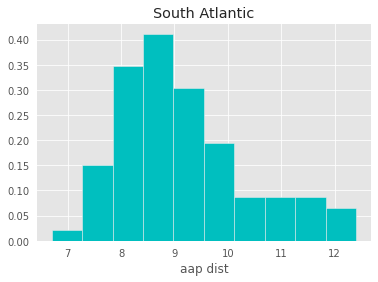

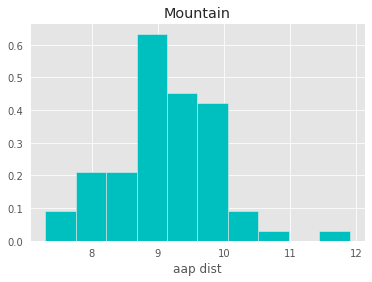

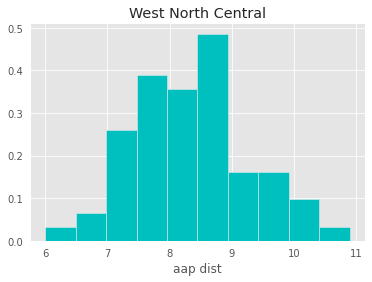

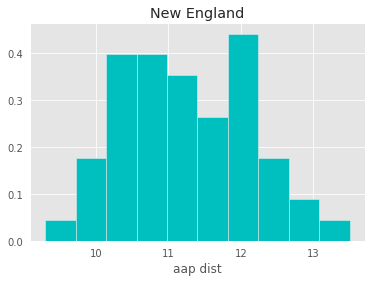

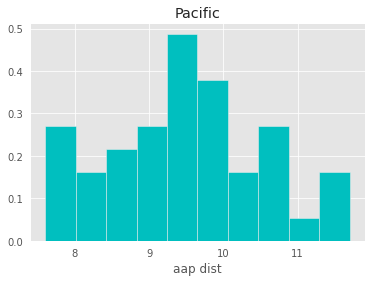

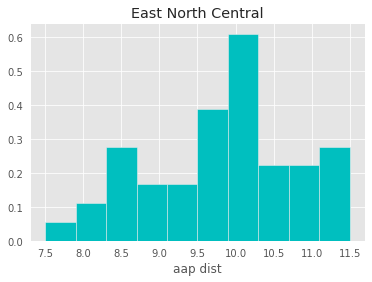

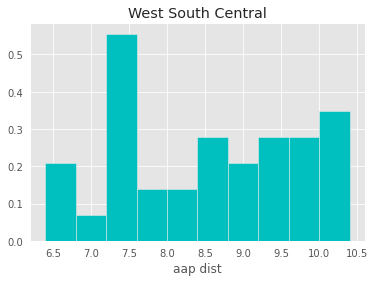

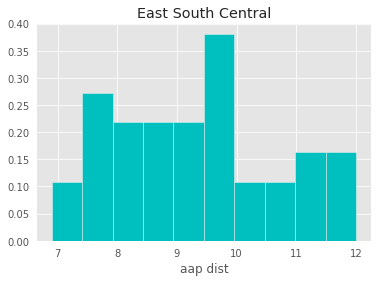

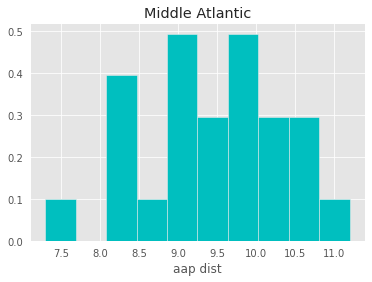

In [7]:
for div in aap["div"].value_counts().index:
  plt.figure(div)
  plt.hist(aap[aap["div"]==div]["aap"], density= 1, color = 'c');
  plt.xlabel("aap dist")
 # plt.ylabel("density")
  plt.title(div);

 those are some relatively normal looking distributions that do not conation obvious outliers, we'll do QQ-plots to be certain

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

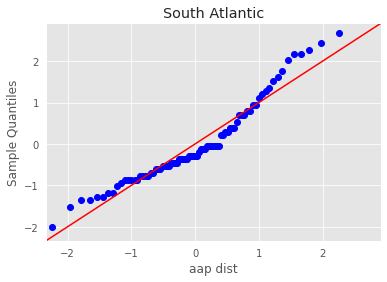

<Figure size 432x288 with 0 Axes>

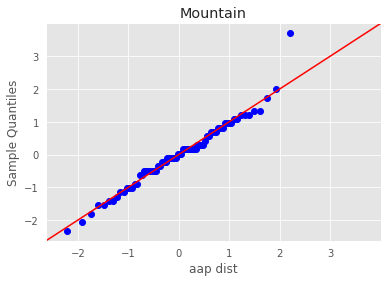

<Figure size 432x288 with 0 Axes>

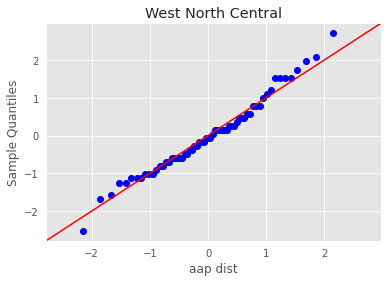

<Figure size 432x288 with 0 Axes>

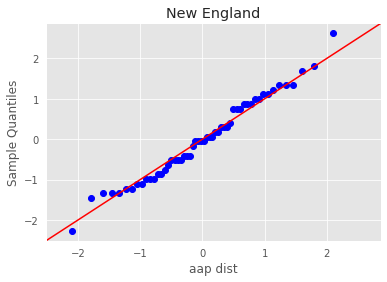

<Figure size 432x288 with 0 Axes>

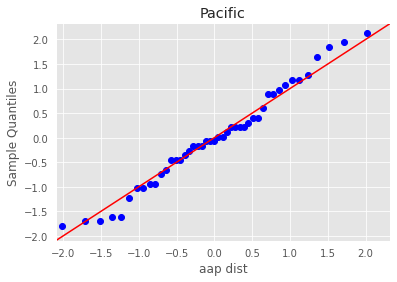

<Figure size 432x288 with 0 Axes>

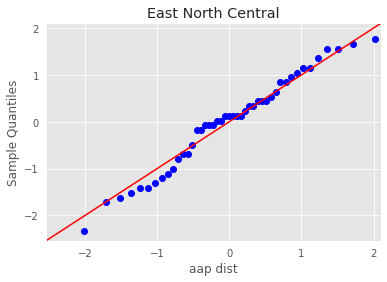

<Figure size 432x288 with 0 Axes>

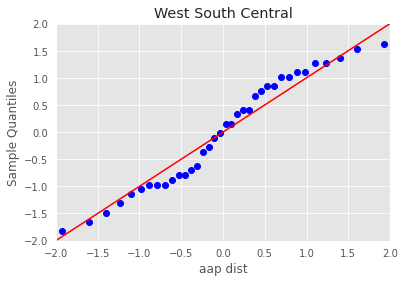

<Figure size 432x288 with 0 Axes>

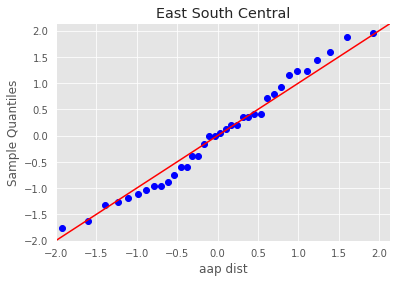

<Figure size 432x288 with 0 Axes>

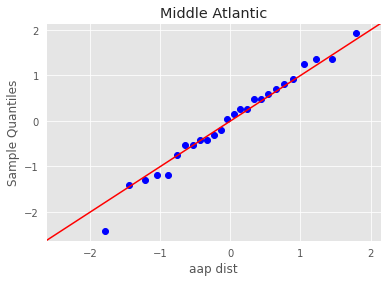

In [8]:
import statsmodels.api as sm
import pylab as py
for div in aap["div"].value_counts().index:
  plt.figure(div)
  #plt.hist(, density= 1, color = 'c');
  sm.qqplot(aap[aap["div"]==div]["aap"], line = "45", fit = True);
  plt.xlabel("aap dist")
 # plt.ylabel("density")
  plt.title(div);

In [9]:
aap["div"].value_counts().index


Index(['South Atlantic', 'Mountain', 'West North Central', 'New England',
       'Pacific', 'East North Central', 'West South Central',
       'East South Central', 'Middle Atlantic'],
      dtype='object')

In [10]:
overall_mean = np.mean(aap["aap"])

division_means = aap.groupby("div").agg(np.mean)
division_counts = aap.groupby("div").count()

division_means["count"] = division_counts["aap"]
division_means

,year,aap,count
div,,,
East North Central,2015.000000,9.777778,45
East South Central,2015.000000,9.322222,36
Middle Atlantic,2014.846154,9.469231,26
Mountain,2015.000000,9.077778,72
New England,2015.000000,11.250000,54
Pacific,2015.000000,9.477778,45
South Atlantic,2015.000000,9.146914,81
West North Central,2015.000000,8.365079,63
West South Central,2015.000000,8.519444,36


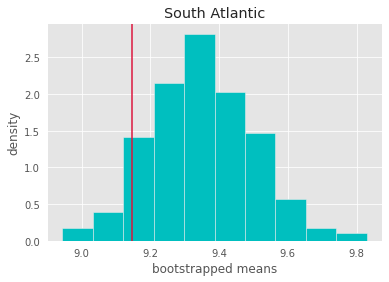

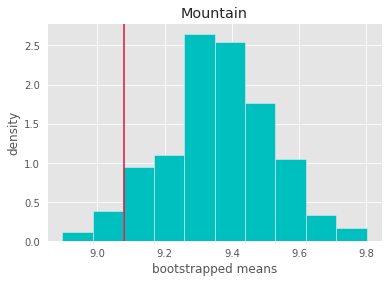

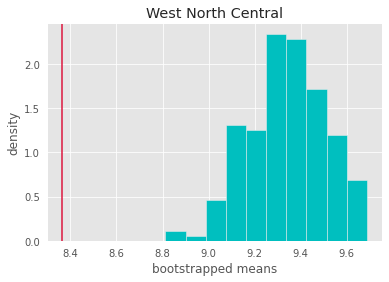

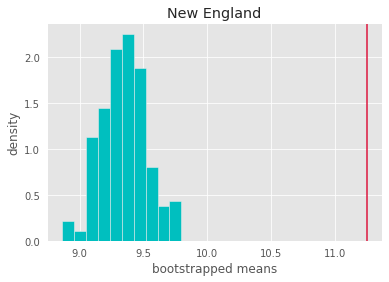

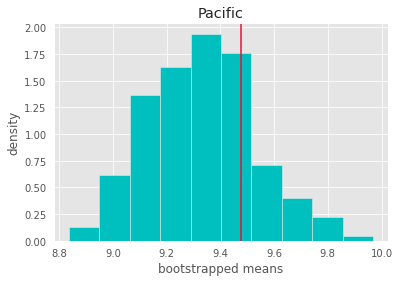

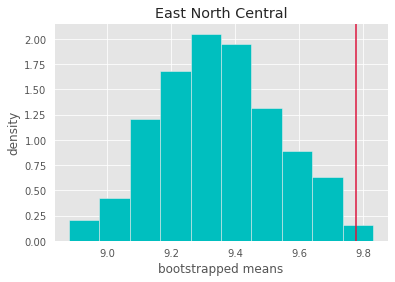

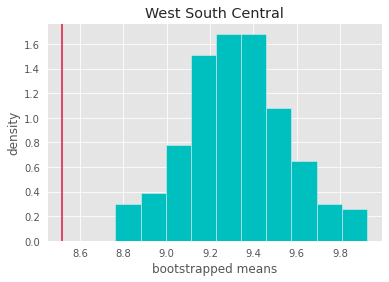

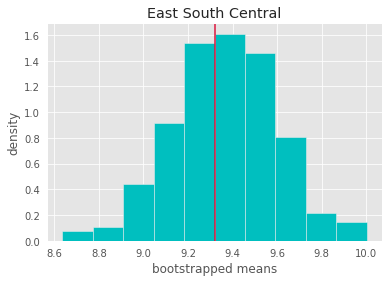

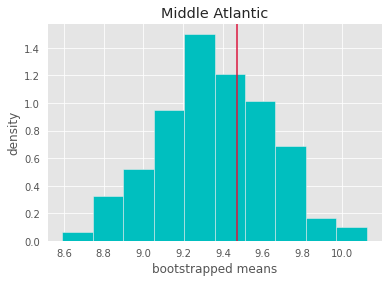

In [11]:

prevs = np.array(aap["aap"])
p_values_above = []
p_values_below = []
#We want to do some bootstrapping for every division
for div in aap["div"].value_counts().index:
  size = division_means.loc[div,"count"]
  actual_mean = division_means.loc[div,"aap"]
  boot_means = []
  #bootstrap step
  for _ in np.arange(200):
    boot = np.random.choice(prevs, replace = True, size = size )
    boot_means.append(np.mean(boot))

  #save the p-values

  #suppose null-the given region does not have more asthma prevelence than the general populace
  pval_above = sum(boot_means>actual_mean)/200
  p_values_above.append(pval_above)

  #suppose null-the given region does not have lower asthma prevelence than the general populace
  pval_below = sum(boot_means<actual_mean)/200
  p_values_below.append(pval_below)

  #plot our findings
  plt.figure(div)
  plt.hist(boot_means, density= 1, color = 'c');
  plt.xlabel("bootstrapped means")
  plt.ylabel("density")
  plt.title(div);
  plt.axvline(actual_mean, color="crimson");
  plt.savefig(div)

In [12]:
pval_df = pd.DataFrame(aap["div"].value_counts().index)

pval_df["p_vals_above"] = p_values_above
pval_df["p_vals_below"] = p_values_below

In [13]:
pval_df

,0,p_vals_above,p_vals_below
0,South Atlantic,0.935,0.065
1,Mountain,0.955,0.045
2,West North Central,1.000,0.000
3,New England,0.000,1.000
4,Pacific,0.205,0.790
5,East North Central,0.010,0.990
6,West South Central,1.000,0.000
7,East South Central,0.560,0.440
8,Middle Atlantic,0.335,0.660


In [14]:
#TODO -- Bonferroni or B-H for Group-wise error rates
#borrowed from lab01 **B-H requires null p-vals to be indep


alpha = 0.05
def benjamini_hochberg(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    n = len(p_values)
    K = np.arange(n)
    p_values_copy = p_values.copy()
    p_values_copy.sort()
    
    opt_p = 0
    
    for k in K:
        if p_values_copy[k] <= [(k+1)*alpha/n]:
            
            opt_p = p_values_copy[k]
   

    decisions = p_values <= opt_p
    return decisions

above_decisions = benjamini_hochberg(p_values_above, alpha)
below_decisions = benjamini_hochberg(p_values_below, alpha)

pval_df["B-H reject null(is above)"] = above_decisions
pval_df["B-H reject null(is below)"] = below_decisions


In [15]:
#Bonferroni also from lab01
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    m = len(p_values)
    decisions = p_values <= (alpha_total/m)
    return decisions

    above_decisions = bonferroni(np.array(p_values_above), alpha)
below_decisions = bonferroni(np.array(p_values_below), alpha)

pval_df["Bonferroni reject null(is above)"] = above_decisions
pval_df["Bonferroni reject null(is below)"] = below_decisions

In [16]:
pval_df

,0,p_vals_above,p_vals_below,B-H reject null(is above),B-H reject null(is below),Bonferroni reject null(is above),Bonferroni reject null(is below)
0,South Atlantic,0.935,0.065,False,False,False,False
1,Mountain,0.955,0.045,False,False,False,False
2,West North Central,1.000,0.000,False,True,False,True
3,New England,0.000,1.000,True,False,True,False
4,Pacific,0.205,0.790,False,False,False,False
5,East North Central,0.010,0.990,True,False,True,False
6,West South Central,1.000,0.000,False,True,False,True
7,East South Central,0.560,0.440,False,False,False,False
8,Middle Atlantic,0.335,0.660,False,False,False,False
